# Machine Learning using Tensorflow

In this notebook we will solve two simple exercises using low-level
Tensorflow.

Table of Contents:

- [ 1 Iterative division](#1-Iterative-division)
- [ 2 Neural function approximator](#2-Neural-function-approximator)

In [1]:
import time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot
# Always make sure you are using running the expected version.
# There are considerable differences between versions...
tf.__version__

'1.4.1'

In [2]:
%run -i _derived/2_visualize_graph.py
# (Load code helper code cell -- make sure to have executed notebook "2_tf_basics" first.)

# 1 Iterative division

Using [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)
to iteratively solve a division:
We first define our graph `a_times_b = a * b` and then we provide both
`a` and `a_times_b`, and set an initial guess of `b` to zero. We then
iteratively improve our guess for `b` by minimizing the square of the
difference of `a_times_b` (=target) and `a * b`.

Note that we do not need to specify any gradients -- Tensorflow's
`GradientDescentOptimizer` can simply look at our "forward graph" and
then generate a "backward graph" starting from our loss that consists
of the gradients!

In [3]:
# Use new graph for this section to keep things tidy.
graph = tf.Graph()

In [4]:
# Define our calculation + loss.

with graph.as_default():
    a = tf.placeholder(shape=(), dtype=tf.float32, name='a')
    b = tf.Variable(0.0, name='b')
    a_times_b = tf.placeholder(shape=(), dtype=tf.float32, name='a_times_b')
    # Use overloaded Python operators for convenience.
    # (this will translate to tf.mul(), tf.sub(), and tf.pow())
    loss = (a_times_b - a * b) ** 2
    # Let's use the identity Op to add a name to the "loss" tensor.
    loss = tf.identity(loss, name='loss')

    show_graph(tf.get_default_graph())

In [5]:
# Magic happens : add optimizer.

with graph.as_default():
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    # We can now minimize the loss by calling this train_op (many times),
    # which will change the value of "b" upon every invocation a bit in such
    # a way that the loss becomes smaller.
    train_op = optimizer.minimize(loss)

    show_graph(tf.get_default_graph())

In [6]:
# Do the computation.

with tf.Session(graph=graph) as sess:
    # Variables must be initialized before first use.
    tf.global_variables_initializer().run()
    # Feed the same result at every step.
    feed_dict = {a: 2, a_times_b: 42}

    print 'b=', sess.run([b])
    for i in range(10):
        # Update b by calling train_op.
        sess.run([train_op], feed_dict=feed_dict)
        # Print our updated guess for b.
        print 'b=', sess.run([b])

b= [0.0]
b= [16.800001]
b= [20.16]
b= [20.832001]
b= [20.9664]
b= [20.99328]
b= [20.998655]
b= [20.999731]
b= [20.999947]
b= [20.999989]
b= [20.999998]


# 2 Neural function approximator

Neural networks can be seen as generic function approximators
`y = f(x)` -- in this section we will use a network to approximate
a simple mathematical function with a scalar input.

The same approach can be used to train arbitrary function (for example
a function where `x` is a dense vector of a megapixel image, and `y` is
a probability distribution over thousands of different object classes).

A crucial part when designing such a network is a good choice of
"hyperparameters" that define *how* the network should be created and
trained.

In [7]:
# Helper class for function approximation. Defining all the code
# in a single class makes it easier to instantiate different
# "versions" of the approximator (to approximate different functions
# with different configurations).

class FunctionApproximator(object):
    """A class for function approximation using Tensorflow.

    This class implements both building the graph and updating the
    variables to better approximate the target function, so that it
    can be instantiated with different functions/configurations.
    """

    def __init__(self, f, hidden_layers):
        """Initializes a new function approximator.
        
        Args:
          f: Scalar Python functional that should be approximated.
            Signature: f(x:Number) -> Number
          hidden_layers: Iterable specifying number of units per layer.
        """
        self.f = f
        self.hidden_layers = hidden_layers
        # Initialize new graph that only contains Ops needed for
        # function approximation.
        self.graph = tf.Graph()
        with self.graph.as_default():
            self._build()
        self.init()

    def init(self):
        """Initializes weights."""
        self.sess = tf.Session(graph=self.graph)
        self.init_op.run(session=self.sess)

    def _build(self):
        # The values for "x" and "y" are provided during training.
        # Note the dynamic first dimension (=number of samples in batch).
        self.x = tf.placeholder(shape=(None,), dtype=tf.float32)
        self.y = tf.placeholder(shape=(None,), dtype=tf.float32)
        # Reshape e.g. [1, 2, 3] to [[1], [2], [3]] because this latter
        # shape is required by tf.layers() below.
        x = tf.reshape(self.x, (-1, 1))
        for units in self.hidden_layers:
            # We use tf.layers() helper function to create "fully connected
            # layers" where every neuron is connected to every neuron in the
            # previous layer. This helper function takes care of defining
            # variables and initializing them.
            x = tf.layers.dense(inputs=x, units=units, activation=tf.nn.relu)
        # Our predicted "y".
        self.y_ = tf.layers.dense(inputs=x, units=1, activation=None)
        # Reshape e.g. [[1], [2], [3]] (by tf.layers()) to [1, 2, 3].
        self.y_ = tf.reshape(self.y_, (-1,))

        # Compute loss.
        self.loss = tf.reduce_mean((self.y - self.y_)**2)
        # Add Ops for minimizing loss.
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        self.train_op = optimizer.minimize(self.loss)
        self.init_op = tf.global_variables_initializer()

    def fit(self, x_min, x_max, steps, batch_size, show_progress=False):
        """Fits the weights to better approximate the function.

        This function will generate random samples "x" within [x_min, x_max]
        and update the network's weight to better approximate y=f(x).

        Args:
          x_min: Lower bound for generation of "x".
          x_max: Upper bound for generation of "x".
          steps: Number of training steps.
          batch_size: Number of samples to train network with in every step.
        """
        t0 = time.time()

        losses = []
        for step in range(steps):
            # Generate samples.
            x_data = np.random.uniform(low=x_min, high=x_max, size=batch_size)
            y_data = self.f(x_data)
            feed_dict = {
                self.x: x_data,
                self.y: y_data
            }
            # Update the weights and get the loss.
            loss_data, _ = self.sess.run([self.loss, self.train_op], feed_dict=feed_dict)
            losses.append(loss_data)
            if show_progress and step % (steps // 10) == 0:
                print 'step=%6d loss=%f' % (step, loss_data)

        dt = time.time() - t0
        return losses, dt

    def predict(self, x_data):
        """Computes approximated function values."""
        return self.sess.run([self.y_], {self.x: x_data})[0]

step=     0 loss=0.615165
step=  1000 loss=0.021150
step=  2000 loss=0.005446
step=  3000 loss=0.001960
step=  4000 loss=0.000976
step=  5000 loss=0.000472
step=  6000 loss=0.000363
step=  7000 loss=0.000211
step=  8000 loss=0.000172
step=  9000 loss=0.000112
31.89 seconds


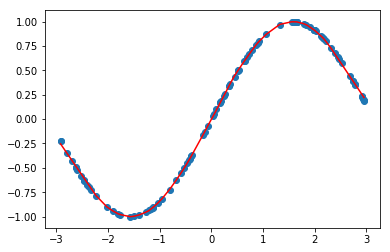

In [8]:
# "hidden_layers" specifies the number of neurons per layer.
# The network will be trained with batch_size x "steps" random datapoints.

### YOUR ACTION REQUIRED:
# Try to achieve a good function approximation by finding good parameters...
hidden_layers, steps = [100, 50], 10000 #hidden_layers, steps = [5, 5, 5, 5, 5], 1000

tf_sin = FunctionApproximator(f=np.sin, hidden_layers=hidden_layers)

# Train the network.
losses, dt = tf_sin.fit(x_min=-3., x_max=3., steps=steps, batch_size=1000,
                        show_progress=True)
print '%.2f seconds' % dt

# Visualize some predictions
x_data = np.random.uniform(low=-3., high=3., size=100)
x_data.sort()
y_data = np.sin(x_data)
y_predictions = tf_sin.predict(x_data)

pyplot.scatter(x_data, y_data)
pyplot.plot(x_data, y_predictions, 'r-')

# A References

Unfortunately, we don't have time to talk about more ML in this
workshop. Two good online references:

- http://deeplearningbook.org (by Ian Goodfellow et al) – more theoretical
- http://neuralnetworksanddeeplearning.com/ (by Michael Nielson) – more hands-on